<a href="https://colab.research.google.com/github/ReidelVichot/DEFreightProfiles/blob/main/Roads_Tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Import CCD from google drive Source: Census
ccd_name = "/content/drive/My Drive/FreightProfiles/tl_rd22_10_cousub (1)/tl_rd22_10_cousub.shp"
ccd =  gpd.read_file(ccd_name)
# Import tracks from google drive
# Source: Fist Maps
# https://de-firstmap-delaware.hub.arcgis.com/datasets/railroad-rail-lines/explore?location=39.655622%2C-75.765561%2C13.56
rail_name = "/content/drive/MyDrive/FreightProfiles/Delaware_Multimodal_2.0_tracks/Delaware_Multimodal_2.0.shp"
rail = gpd.read_file(rail_name)

In [14]:
rail.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

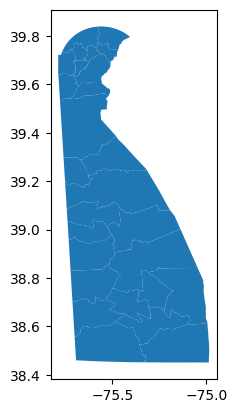

In [13]:
ccd.plot()

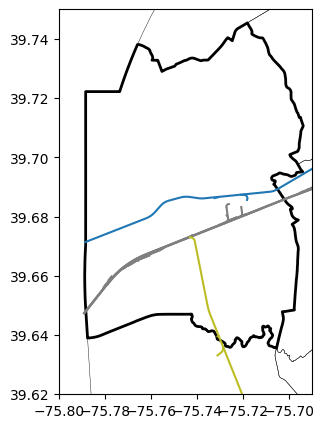

In [53]:
fig, ax = plt.subplots(figsize =(5,5))

ccd.plot(facecolor = "none", lw = 0.3, ax=ax)
ccd[ccd["NAME"]=="Newark"].plot(facecolor = "none", lw = 2 , ax=ax)
#rail.to_crs(ccd.crs).plot("OWNER", legend=True,  ax=ax)
rail.to_crs(ccd.crs).plot("OWNER",   ax=ax)

ax.set_xlim(-75.8, -75.69)
ax.set_ylim(39.62, 39.75)

fig.show()



In [59]:
ccd = ccd.to_crs(rail.crs)

# Get the intersection of the line and the polygon
intersection = gpd.overlay(rail, ccd[ccd["NAME"]=="Newark"], how="intersection")


# Get the length of the intersection
intersection.length.sum()

# Print the result
#print(f"The length of the line within the polygon is {length:.2f} units.")

/usr/local/lib/python3.10/dist-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


0.0

<Axes: >

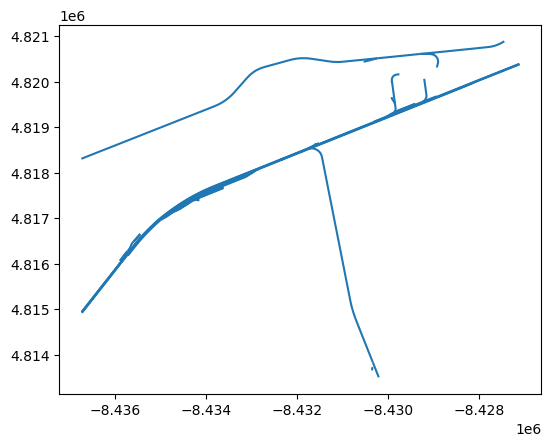

In [65]:
ccd = ccd.to_crs(rail.crs)
gpd.overlay(rail, ccd[ccd["NAME"]=="Newark"], how="intersection").plot()

In [47]:
rail.groupby("OWNER").sum(numeric_only=True)

,OBJECTID,RAIL_ID,SHAPELEN
OWNER,,,
CSX Transportation,81071,104119,104323.499467
Consolidated Rail Corporation,1773,4244,99.278855
East Penn Railroad LLC,8118,12829,21135.068261
"Evraz Claymont Steel, Inc.",4601,8055,852.578775
Historic Red Clay Valley,26543,34510,24025.983964
Maryland & Delaware Railroad Company,15593,21431,27822.395894
NRG Energy Inc.,16132,24084,13816.201910
National Railroad Passenger Corporation,303215,343621,222546.265532
Norfolk Southern Corporation,664935,991599,586296.955750
